<a href="https://colab.research.google.com/github/ChiomaO15/ChiomaO15/blob/main/PREDICTION_MODEL_TO_PREDICT_FUNCTION_OF_UNANNOTATED_GENES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LOADING DATA**

In [113]:
!pip install biopython

In [90]:
import pandas as pd
from Bio import SeqIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE


In [91]:
# Step 1: Parse the FASTA file
fasta_file = "/content/B.Amyloliqufaciens contigs.fasta"
fasta_data = {}

print("Parsing FASTA file...")
for record in SeqIO.parse(fasta_file, "fasta"):
    fasta_data[record.id] = str(record.seq)

Parsing FASTA file...


In [92]:
# Normalize FASTA gene IDs
normalized_fasta_data = fasta_data  # We already normalized by stripping and converting to lowercase


In [93]:
# Step 2: Load the annotation file
annotation_file = "/content/b.amyloliqufaciens converted_file annotation.csv"
annotations_df = pd.read_csv(annotation_file)
annotations_df['Gene ID'] = annotations_df['Gene ID'].str.strip()  # Clean up whitespace

print("Annotations file loaded. First few rows:")
print(annotations_df.head())

Annotations file loaded. First few rows:
                              Gene ID Unnamed: 1  Start position  \
0  NODE_609_length_1663_cov_57.444515      KBase               1   
1  NODE_609_length_1663_cov_57.444515      KBase               1   
2  NODE_609_length_1663_cov_57.444515      KBase               1   
3  NODE_609_length_1663_cov_57.444515      KBase               1   
4  NODE_609_length_1663_cov_57.444515      KBase             146   

   End position Unnamed: 4 Unnamed: 5  Unnamed: 6  \
0           105          .          +           0   
1           105          .          +           0   
2           105          .          +           0   
3           105          .          +           0   
4          1408          .          +           0   

                                             Product  
0           ID=B.amyloliqufaciensannotation.CDS.3150  
1  ID=B.amyloliqufaciensannotation.CDS.3150_mRNA;...  
2  ID=B.amyloliqufaciensannotation.CDS.3150_mRNA_...  
3  ID=B.amy

In [94]:
# Step 3: Merge FASTA sequences with annotations
print("Merging FASTA data with annotations...")
merged_data = []

for gene_id, sequence in fasta_data.items():
    if gene_id in annotations_df['Gene ID'].values:
        product = annotations_df[annotations_df['Gene ID'] == gene_id]['Product'].values[0]
    else:
        product = "unknown"  # Label unannotated genes
    merged_data.append({'gene_id': gene_id, 'sequence': sequence, 'product': product})

merged_df = pd.DataFrame(merged_data)

print("Merged data:")
print(merged_df.head())

Merging FASTA data with annotations...
Merged data:
                              gene_id  \
0   NODE_1_length_43775_cov_49.908028   
1   NODE_2_length_41648_cov_96.217820   
2  NODE_3_length_39211_cov_595.858384   
3  NODE_4_length_30081_cov_184.695774   
4   NODE_5_length_27359_cov_48.108386   

                                            sequence  \
0  AAGAGAAGGCCGCTGTACGTGAAAAAGCGCCGATCCATTTCAAAGC...   
1  ATTTTTTCTTCAGTCCTTTAGGTTCTCTATCATGATAAACATCCTG...   
2  AACAGCCTTTCTTTCTCATATTGGACGAGCTGGAAGACCCTCATAA...   
3  CTTCCTTTATCATAAAACATTTTTCTCTAATTAGAAAGAAGAATGT...   
4  AAAAAATAGTGTATCTGTTTTATCCGTTTCAATTTCCCGTGCGGAA...   

                                             product  
0  ID=B.amyloliqufaciensannotation.CDS.1; product...  
1  ID=B.amyloliqufaciensannotation.CDS.5; product...  
2  ID=B.amyloliqufaciensannotation.CDS.13; produc...  
3  ID=B.amyloliqufaciensannotation.CDS.68; produc...  
4  ID=B.amyloliqufaciensannotation.CDS.95; produc...  


I discovered my product column did not show the exact product so i cleaned the data to show the exact product stated in the annotation file

In [95]:
# Merge data with cleaned product names
merged_data = []
for gene_id, sequence in normalized_fasta_data.items():
    if gene_id in annotations_df['Gene ID'].values:
        full_product = annotations_df[annotations_df['Gene ID'] == gene_id]['Product'].values[0]
        # Extract product name after "product="
        if "product=" in full_product:
            product = full_product.split("product=")[-1].split(";")[0].strip()
        else:
            product = "unknown"
    else:
        product = "unknown"
    merged_data.append({'gene_id': gene_id, 'sequence': sequence, 'product': product})


In [96]:
merged_df = pd.DataFrame(merged_data)

print("Merged data:")
print(merged_df.head())


Merged data:
                              gene_id  \
0   NODE_1_length_43775_cov_49.908028   
1   NODE_2_length_41648_cov_96.217820   
2  NODE_3_length_39211_cov_595.858384   
3  NODE_4_length_30081_cov_184.695774   
4   NODE_5_length_27359_cov_48.108386   

                                            sequence  \
0  AAGAGAAGGCCGCTGTACGTGAAAAAGCGCCGATCCATTTCAAAGC...   
1  ATTTTTTCTTCAGTCCTTTAGGTTCTCTATCATGATAAACATCCTG...   
2  AACAGCCTTTCTTTCTCATATTGGACGAGCTGGAAGACCCTCATAA...   
3  CTTCCTTTATCATAAAACATTTTTCTCTAATTAGAAAGAAGAATGT...   
4  AAAAAATAGTGTATCTGTTTTATCCGTTTCAATTTCCCGTGCGGAA...   

                                             product  
0                        Modular polyketide synthase  
1  Osmosensitive K%2B channel histidine kinase Kd...  
2  23S rRNA %28guanosine%282251%29-2%27-O%29-meth...  
3                       Uncharacterized protein YmfJ  
4                        Modular polyketide synthase  


In [97]:
# Step 4: Separate Annotated and Unannotated Genes
annotated_data = merged_df[merged_df['product'] != "unknown"]
unannotated_data = merged_df[merged_df['product'] == "unknown"]


In [98]:
print(f"Number of annotated genes: {len(annotated_data)}")
print(f"Number of unannotated genes: {len(unannotated_data)}")


Number of annotated genes: 1078
Number of unannotated genes: 1132


In [99]:
# Save merged data for reference
merged_df.to_csv("/content/merged_fasta_with_annotations.csv", index=False)
print("Merged data saved to /content/merged_fasta_with_annotations.csv")

Merged data saved to /content/merged_fasta_with_annotations.csv


In [100]:
# Step 5: Feature extraction (GC Content and K-mers)
def calculate_gc_content(sequence):
    """Calculate GC content of a sequence."""
    g_count = sequence.count("G")
    c_count = sequence.count("C")
    return (g_count + c_count) / len(sequence) * 100

def extract_kmers(sequence, k=3):
    """Extract k-mer frequencies."""
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return Counter(kmers)

def extract_features(data, k=3):
    """Extract GC content and k-mer frequencies for each gene."""
    features = []
    for _, row in data.iterrows():
        sequence = row['sequence']
        gc_content = calculate_gc_content(sequence)
        kmer_freqs = extract_kmers(sequence, k)
        feature_vector = [gc_content] + list(kmer_freqs.values())
        features.append(feature_vector)
    return pd.DataFrame(features)

In [101]:
print("Extracting features for annotated genes...")
X_annotated = extract_features(annotated_data)
y_annotated = annotated_data['product']

Extracting features for annotated genes...


In [102]:
# Step 6: Train Random Forest model
print("Training Random Forest model...")
X_train, X_test, y_train, y_test = train_test_split(X_annotated, y_annotated, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100,class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

Training Random Forest model...


RandomForestClassifier(class_weight='balanced', random_state=42)

In [103]:
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
                                                                                                                                                                                                                                                                      precision    recall  f1-score   support

                                                                                                                                                                                                                                   %5B4Fe-4S%5D-AdoMet protein YtqA       0.00      0.00      0.00         0
                                                                                                                                                                                                             2-amino-3-carboxymuconate-6- semialdehydedecarboxylase       0.00      0.00      0.00         0
                                                                        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [104]:
# Step 7: Extract features for unannotated genes
print("Extracting features for unannotated genes...")
X_unannotated = extract_features(unannotated_data)


Extracting features for unannotated genes...


In [105]:
# Step 8: Predict functions for unannotated genes
print("Predicting functions for unannotated genes...")
predicted_products = rf_model.predict(X_unannotated)
unannotated_data['predicted_product'] = predicted_products


Predicting functions for unannotated genes...


<ipython-input-105-68e43f1bf714>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['predicted_product'] = predicted_products


In [106]:
# Save the results
output_file = "/content/predicted_unannotated_genes.csv"
unannotated_data.to_csv(output_file, index=False)
print(f"Predicted results saved to {output_file}")


Predicted results saved to /content/predicted_unannotated_genes.csv


In [107]:
# Display a preview of the predicted results
print("Predicted functions for unannotated genes:")
print(unannotated_data[['gene_id', 'predicted_product']].head())

Predicted functions for unannotated genes:
                                gene_id  \
6     NODE_7_length_21663_cov_83.454832   
14  NODE_15_length_16939_cov_166.314376   
56    NODE_57_length_9840_cov_25.752842   
61   NODE_62_length_9659_cov_160.720100   
67   NODE_68_length_9349_cov_133.171915   

                                    predicted_product  
6               Uncharacterized aminotransferase YodT  
14   Polyketide synthase modules and related proteins  
56  D-amino acid dehydrogenase large subunit %28EC...  
61                   Uncharacterized phosphatase YwpJ  
67                          Allergen V5/Tpx-1 related  


Visualization of Results

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns


A bar plot showing the frequency of each predicted product

<ipython-input-109-07ffc9c75148>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis")


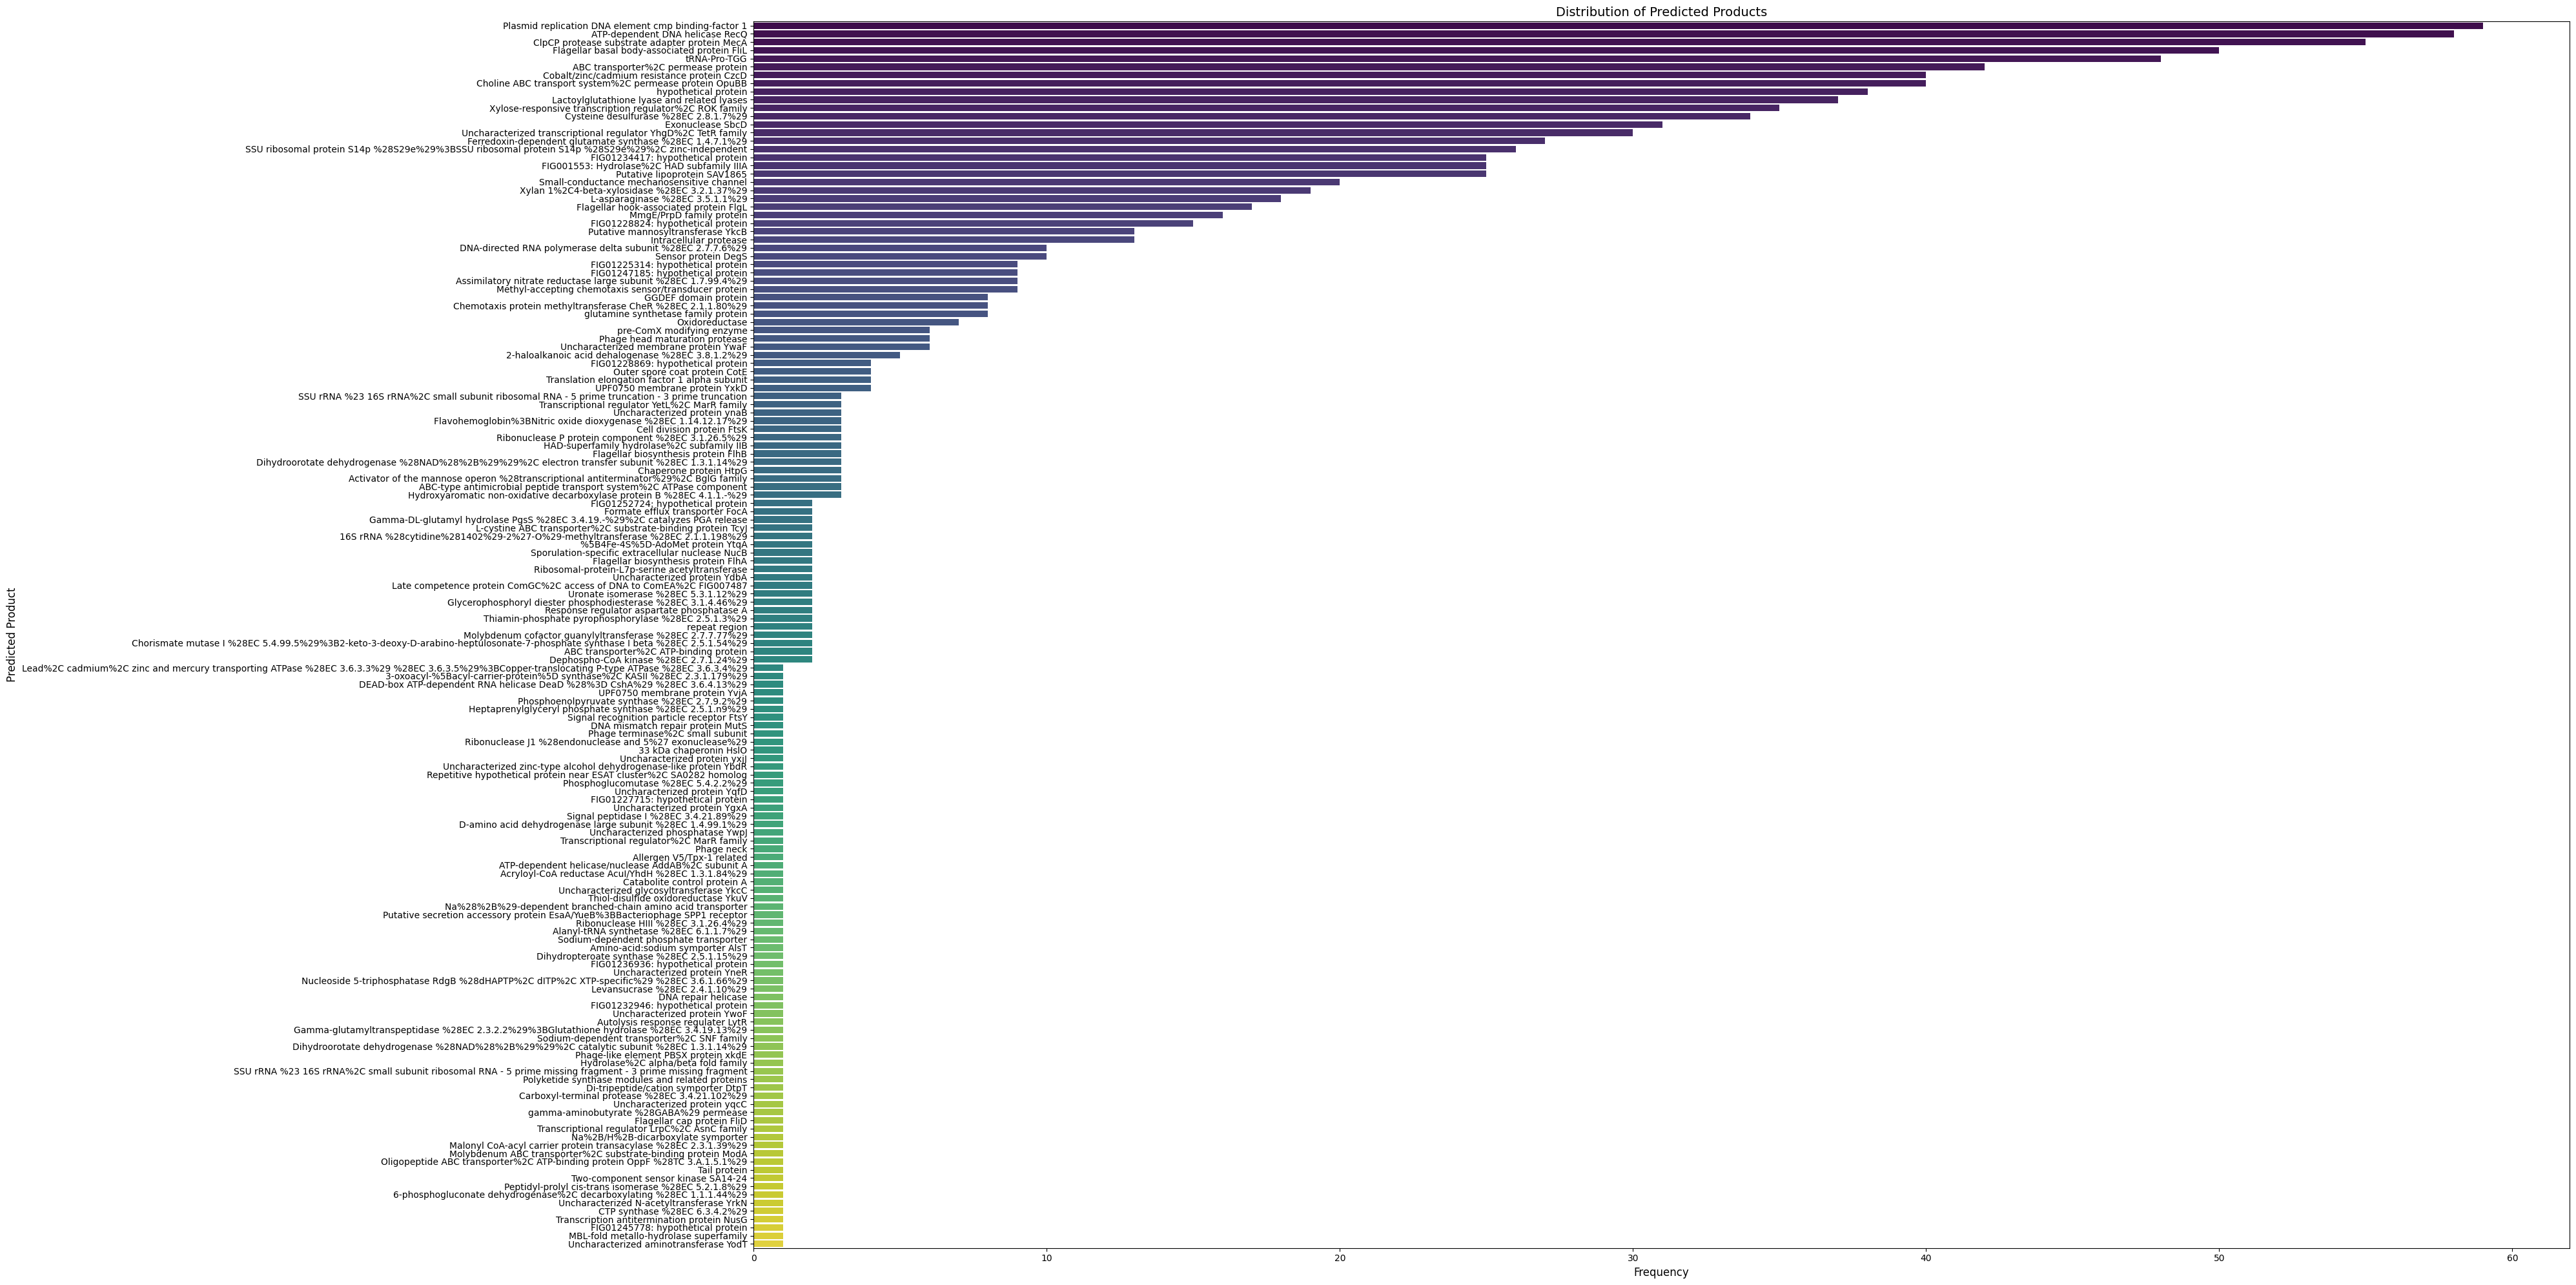

In [109]:
# Count the frequency of each predicted product
product_counts = unannotated_data['predicted_product'].value_counts()

# Create a bar plot
plt.figure(figsize=(40, 20))
sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis")
plt.title("Distribution of Predicted Products", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Predicted Product", fontsize=12)
plt.tight_layout()
plt.show()


Scatter plot showing the relationship between the length and GC content of the sequences

<ipython-input-110-a07d3fad7ce5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['sequence_length'] = unannotated_data['sequence'].apply(len)
<ipython-input-110-a07d3fad7ce5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unannotated_data['gc_content'] = unannotated_data['sequence'].apply(calculate_gc_content)
<ipython-input-110-a07d3fad7ce5>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_

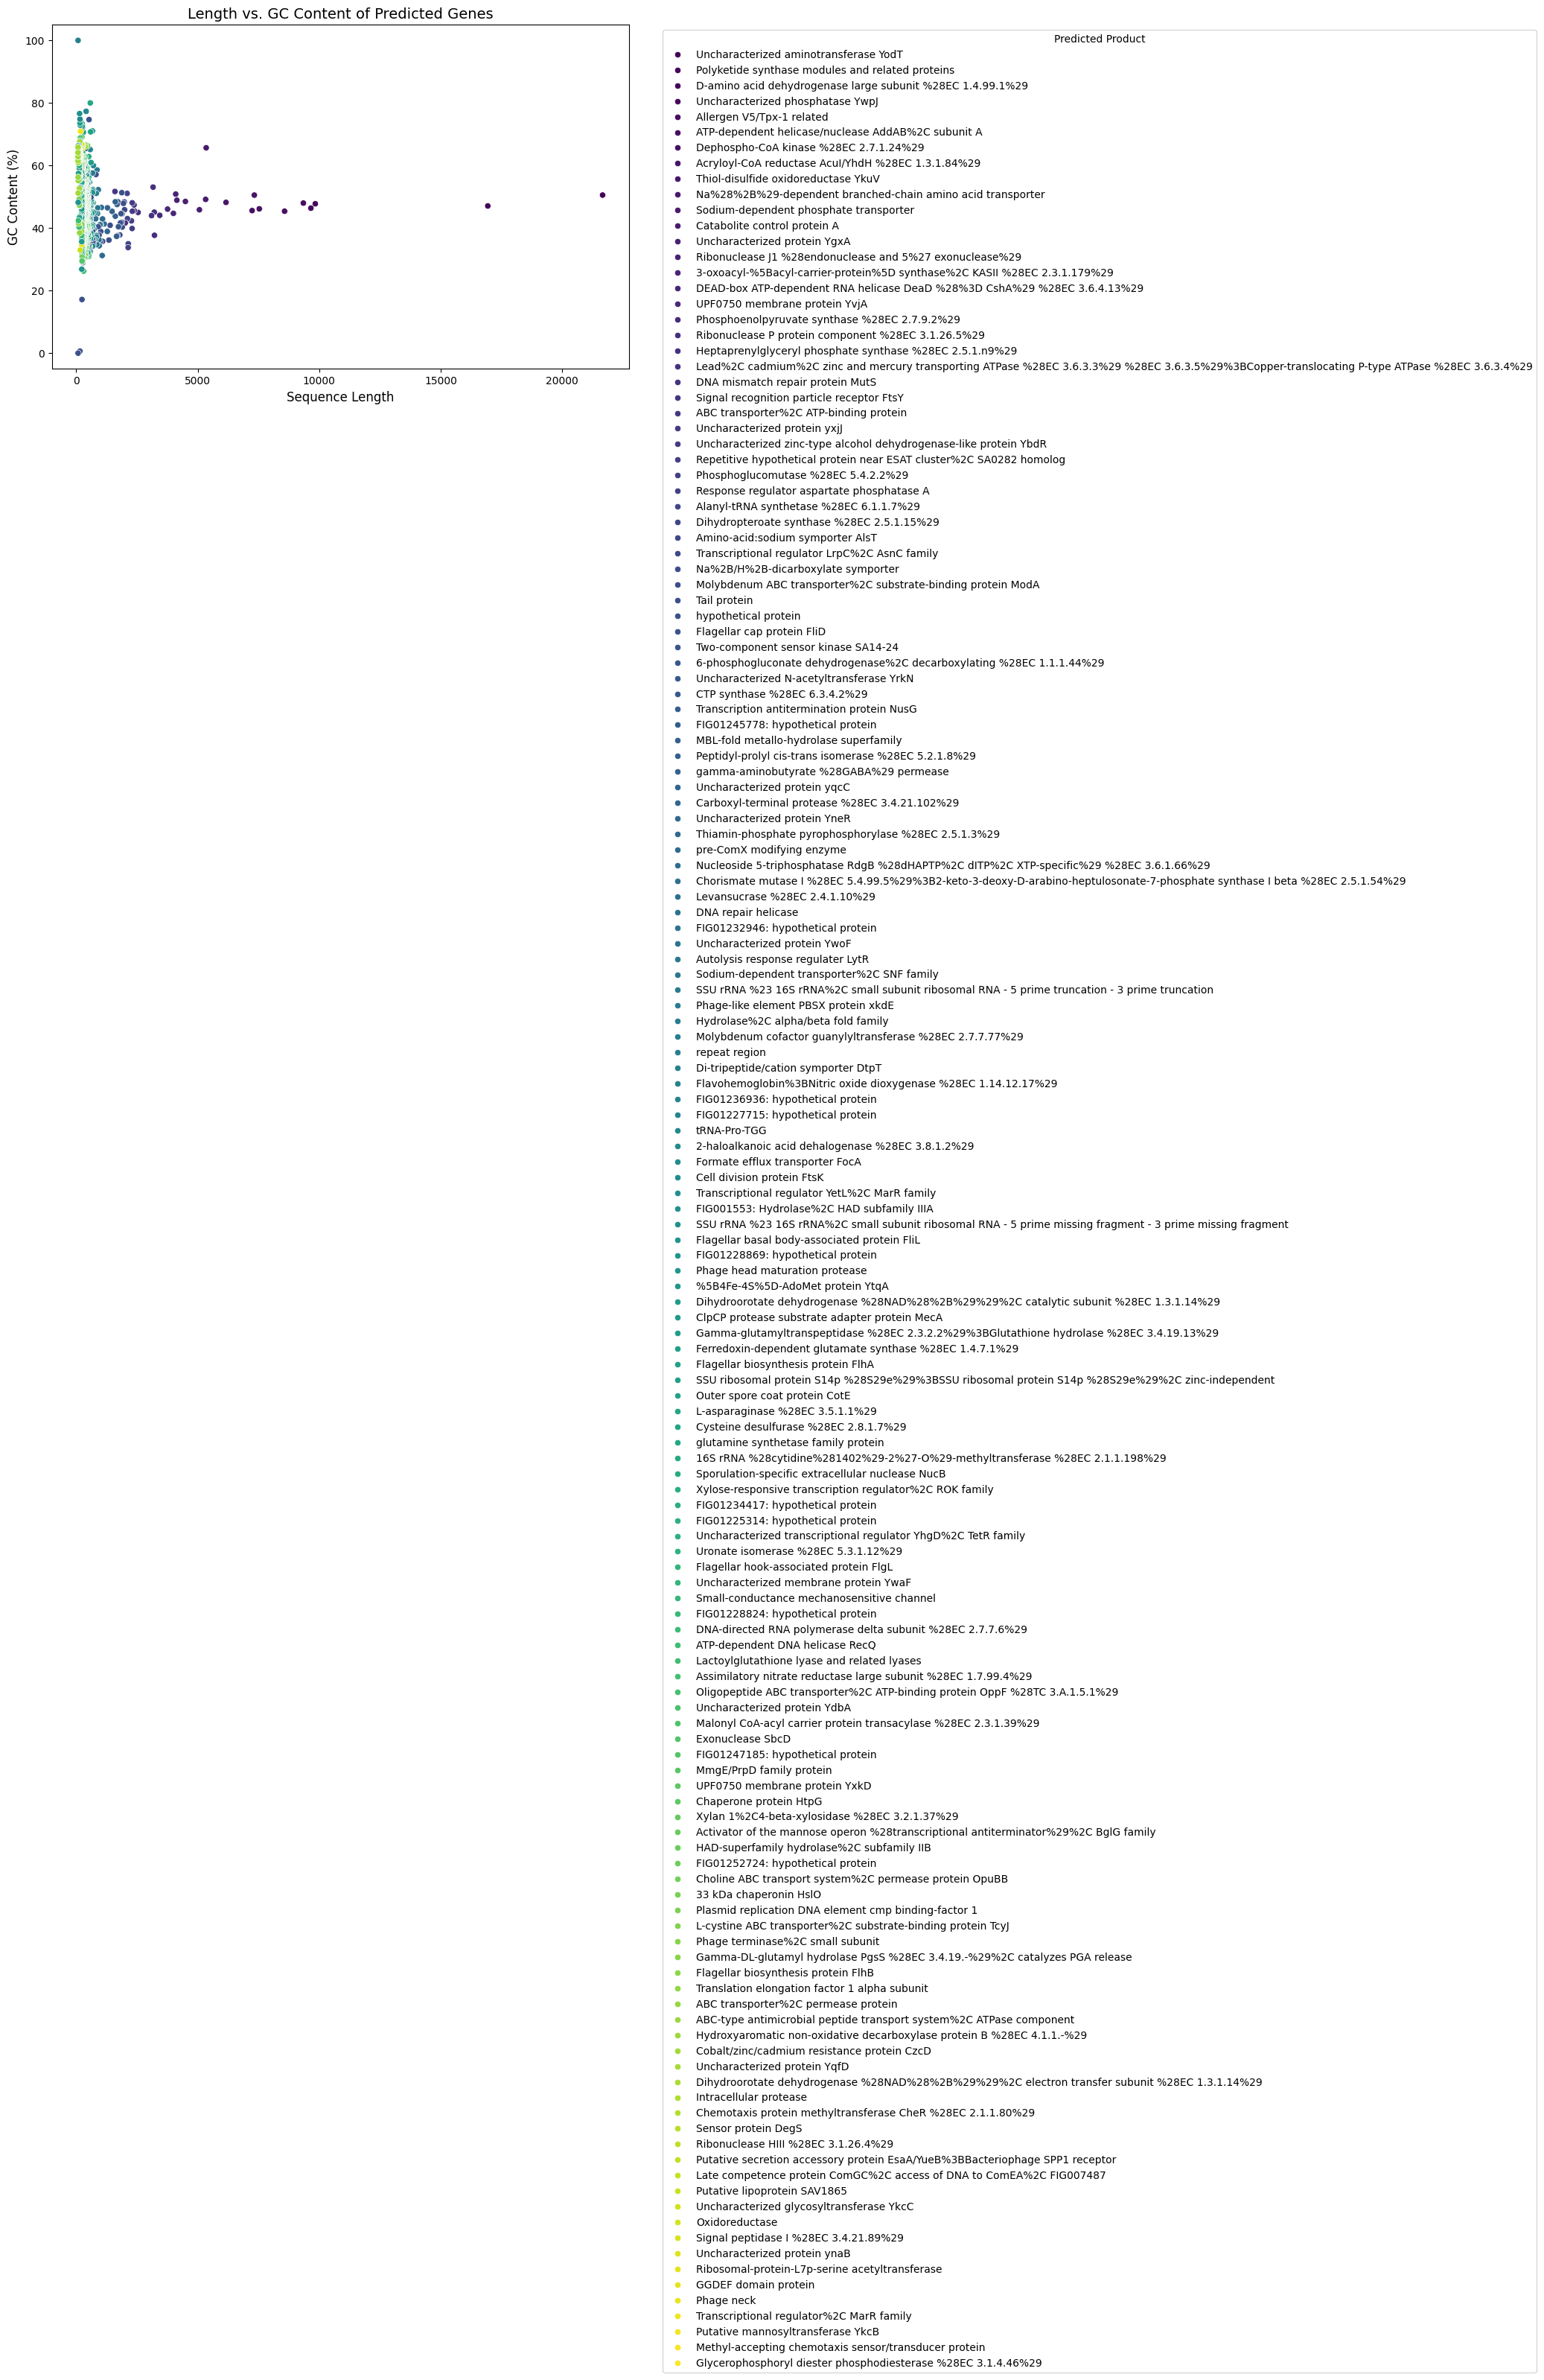

In [110]:
# Extract length and GC content for visualization
unannotated_data['sequence_length'] = unannotated_data['sequence'].apply(len)
unannotated_data['gc_content'] = unannotated_data['sequence'].apply(calculate_gc_content)

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=unannotated_data, x='sequence_length', y='gc_content', hue='predicted_product', palette='viridis')
plt.title("Length vs. GC Content of Predicted Genes", fontsize=14)
plt.xlabel("Sequence Length", fontsize=12)
plt.ylabel("GC Content (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Predicted Product")
plt.tight_layout()
plt.show()


Visualize k-mer frequencies for a subset of sequences as a heatmap

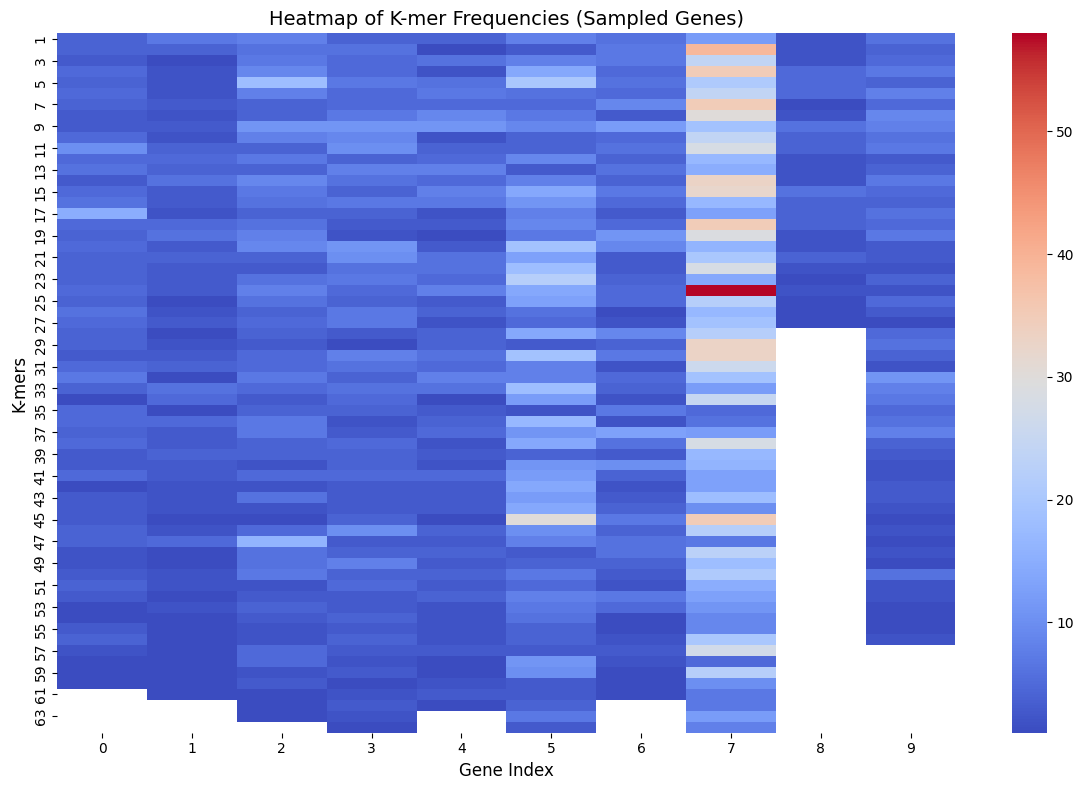

In [111]:
# Extract k-mer features for a sample of unannotated genes
sampled_data = unannotated_data.sample(10, random_state=42)  # Take a sample of 10 genes
sampled_kmers = extract_features(sampled_data).iloc[:, 1:]  # Remove GC content column

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sampled_kmers.T, cmap='coolwarm', cbar=True)
plt.title("Heatmap of K-mer Frequencies (Sampled Genes)", fontsize=14)
plt.xlabel("Gene Index", fontsize=12)
plt.ylabel("K-mers", fontsize=12)
plt.tight_layout()
plt.show()


In [112]:
plt.savefig("/content/plot_name.png", dpi=300)


<Figure size 640x480 with 0 Axes>